## Курсовая работа "Нейрообнаружитель радиолокационных гармонических сигналов".

### Выполнила студентка 631 группы Очнева Инга.


На интервале Т=10 с должен быть обнаружен сигнал u(t)=Asin(Wt+f). Параметры сигнала могут варьироваться в пределах ±30% от номинальных значений: A_ном, W_ном=$0,2\pi$ рад/с (Период 10 с), f_ном с равновероятным распределением.

Обрабатываемый сигнал:

\begin{equation*}
s(t) = 
 \begin{cases}
   Asin(Wt + f) + \xi(t) &\text{когда есть сигнал u(t)}\\
   \xi(t) &\text{иначе}
 \end{cases}
\end{equation*}

где $\xi(t)$ – белый гауссов шум с дисперсией disp.

Обрабатываемый сигнал является выборкой сигнала s(t) с дискретом по времени 1 с.

Числовые значения параметров сигнала Aном, fном:

In [167]:
import numpy as np

In [168]:
A_nom = 1
f = 0
disp = 0.7
W = 0.2*np.pi
T = 10

#### Сгенерируем сигналы и шумы.

Будем генерировать num_of_samples строк данных:

In [169]:
num_of_samples = 2000

In [170]:
data_yes = [] # Заведем массив для сигналов (метка "1")
y_yes = np.ones((int(num_of_samples/2), 1)) # Вектор ответов "1"
data_no = [] # Аналогично для шума (метка "0")
y_no = np.zeros((int(num_of_samples/2), 1)) # Вектор ответов "0"

Сгенерируем в цикле наши сигналы, учтя при этом разброс в 30%:

In [171]:
import numpy.random as rn

In [172]:
alpha = 0.3

In [173]:
for i in range(int(num_of_samples/2)):
    for t in range(T):
        to_add = A_nom*np.sin(W*t+f) + A_nom*np.sin(W*t+f)*alpha*np.random.uniform(-1, 1) + np.random.normal(scale=disp)
        data_yes.append(to_add)
        to_add = np.random.normal(scale=disp)
        data_no.append(to_add)

In [174]:
data_yes = np.array(data_yes).reshape((int(num_of_samples/2), T))

In [175]:
data_no = np.array(data_no).reshape((int(num_of_samples/2), T))

In [176]:
import matplotlib.pyplot as plt

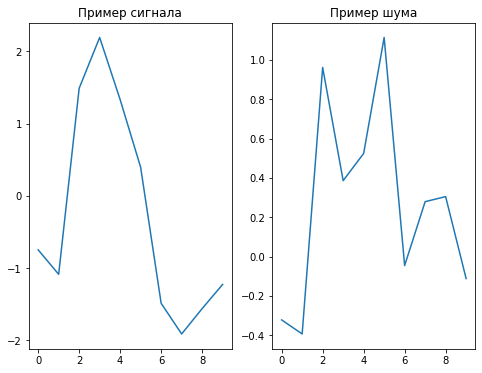

In [177]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 6))
ax1.plot(data_yes[7])
ax1.set_title('Пример сигнала')
ax2.plot(data_no[5])
ax2.set_title('Пример шума')
plt.show()


Визуально отличить сигнал от шума невозможно. Посмотрим, сможет ли нейросеть выделить незаметную человеку зависимость.

Соберем данные в один объект (матрицу "признаки-ответы"), и затем разделим его на обучение и тест.

In [178]:
import pandas as pd

In [179]:
data_yes = pd.DataFrame(data_yes)

In [180]:
data_no = pd.DataFrame(data_no)

In [181]:
data = pd.concat([data_yes, data_no], ignore_index = True, axis = 0)

In [182]:
data = data.values

In [183]:
targets = pd.concat([pd.DataFrame(y_yes), pd.DataFrame(y_no)], ignore_index = True, axis = 0)

In [184]:
targets = targets.values

In [185]:
from sklearn import model_selection

In [186]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, targets, shuffle=True, 
                                                                                    test_size = 0.25,
                                                                                    random_state = 1)

### Модель нейросети
Составляется конфигурация нейросети:

- Распределительный (входной) слой из 10-ти нейронов

- 1-ый рабочий (скрытый) слой из 1– 2-х нейронов (выбирается опытным путем в зависимости от ошибок обнаружителя)

- Выходной слой из 2-х нейронов (один нейрон отвечает за гипотезу «есть сигнал», второй – за гипотезу «нет сигнала»).

- Функции активации: для скрытого слоя – сигмоидная, для выходного слоя – пороговая.

In [187]:
import torch
from torch.nn import Linear, Sigmoid

In [188]:
num_features = train_data.shape[1]
N = 2

In [189]:
mlp = torch.nn.Sequential(
    Linear(num_features, out_features=N), # распределительный слой
    Linear(N, out_features=N), # первый скрытый слой
    torch.nn.Sigmoid(), # сигмоидная активация
    Linear(N, out_features=N), # выходной слой
    torch.nn.Softmax() # активация softmax
)

Далее следует техническая часть работы с библиотекой pytorch:

In [190]:
train_data = torch.autograd.Variable(torch.FloatTensor(train_data))
train_labels = torch.autograd.Variable(torch.LongTensor(train_labels.astype(np.int64)))

test_data = torch.autograd.Variable(torch.FloatTensor(test_data))
test_labels = torch.autograd.Variable(torch.LongTensor(test_labels.astype(np.int64)))

Вручную напишем цикл обучнения сети:

In [191]:
# кросс-энтропия
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)


# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.01  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети 
    y_pred = mlp(train_data)
    # выведем loss на каждом шаге, кратном 10
    loss = loss_fn(y_pred, train_labels.reshape(-1))
    if t%10 == 0:
        print('{} {}'.format(t, loss.data))

    #  обнуляем градиенты перед backard_pass'ом
    
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 1087.644287109375
10 1050.05810546875
20 1025.6412353515625
30 987.7658081054688
40 933.3785400390625
50 877.3837280273438
60 823.81689453125
70 773.9346313476562
80 730.84716796875
90 696.3748168945312
100 669.4976806640625
110 649.05908203125
120 633.5108032226562
130 621.5171508789062
140 612.0723876953125
150 604.4781494140625
160 598.2556762695312
170 593.0692749023438
180 588.6843872070312
190 584.93017578125
200 581.6838989257812
210 578.8505859375
220 576.3583984375
230 574.151123046875
240 572.1832275390625
250 570.4195556640625
260 568.8323364257812
270 567.3950805664062
280 566.0899047851562
290 564.8984985351562
300 563.8096923828125
310 562.807861328125
320 561.8859252929688
330 561.0333251953125
340 560.2437744140625
350 559.5099487304688
360 558.8262939453125
370 558.1856689453125
380 557.5830688476562
390 557.0174560546875
400 556.482666015625
410 555.9743041992188
420 555.48974609375
430 555.0317993164062
440 554.5916748046875
450 554.1741943359375
460 553.7764892578

Сделаем предсказания обученной сетью на тестовой выборке:

In [192]:
proba_pred_train = mlp(train_data)
y_pred_train = proba_pred_train  >  0.5


proba_pred_test = mlp(test_data)
y_pred_test = proba_pred_test > 0.5


### Оценка результатов

Для оценки результатов работы сети воспользуемся confusion matrix - матрицей, где на главной диагонали стоят количества верных классификаций, а на двух оставшихся местах - ошибки типа false positive и false negative.

In [193]:
from sklearn import metrics 
matrix_train = metrics.confusion_matrix(train_labels, y_pred_train[:,1])
print("Матрица ошибок на обучении:")
print(matrix_train)

Матрица ошибок на обучении:
[[732  23]
 [ 50 695]]


In [194]:
matrix_test = metrics.confusion_matrix(test_labels, y_pred_test[:,1])
print("Матрица ошибок на тесте:")
print(matrix_test)

Матрица ошибок на тесте:
[[235  10]
 [ 26 229]]


Итак, нам удалось написать нейросеть, с хорошей точностью классифицирующую созданную нами выборку, тогда как классификация "вручную" взглядом на картину сигнала представляется невозможной.